Sources: [https://cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html#Autocorrelation_plots](https://cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html#Autocorrelation_plots)

In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals, calculate_lag_autocorrelation
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
import xgboost
import lightgbm
import catboost
import sklearn
import shap
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
    PolynomialFeatures,
)
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

import skforecast
from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursive
from skforecast.model_selection import (
    TimeSeriesFold,
    OneStepAheadFold,
    bayesian_search_forecaster,
    backtesting_forecaster,
)
from skforecast.preprocessing import RollingFeatures
from skforecast.feature_selection import select_features
from skforecast.metrics import calculate_coverage

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version lightgbm: {lightgbm.__version__}")
print(f"{color}Version xgboost: {xgboost.__version__}")
print(f"{color}Version catboost: {catboost.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

Version skforecast: 0.15.0
Version scikit-learn: 1.6.1
Version lightgbm: 4.6.0
Version xgboost: 3.0.1
Version catboost: 1.2.8
Version pandas: 2.2.3
Version numpy: 1.24.3


/home/nhatquang/anaconda3/envs/fsds-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



# Business Understanding

## Statement

One of the largest retail chains in the world wants to use their vast data source to build an efficient forecasting model to predict the sales for each SKU in its portfolio at its 76 different stores using historical sales data for the past 3 years on a week-on-week basis. Sales and promotional information is also available for each week - product and store wise.

However, no other information regarding stores and products are available. Can you still forecast accurately the sales values for every such product/SKU-store combination for the next 12 weeks accurately? If yes, then dive right in!

## Data Dictionary

| Field Name        | Data Type / Format                     | Example | Description                                                                                         | Allowed / Expected Range          |
|-------------------|----------------------------------------|---------|-----------------------------------------------------------------------------------------------------|-----------------------------------|
| `record_ID`       | `int64` (sequential key)               | `1`     | Surrogate key, unique for each row. No business meaning.                                            | ≥ 1, unique                        |
| `week`            | `string` date in **YY/MM/DD** (e.g. 17/01/11) | `17/01/11` | Calendar week identifier; usually week‑ending date. Convert to `datetime` for analysis.             | Valid dates                        |
| `store_id`        | `int32`                                | `8091`  | Identifier of the retail outlet. Links to **Store** dimension.                                      | Positive integers                  |
| `sku_id`          | `int32`                                | `216418`| Identifier for the Stock‑Keeping Unit. Links to **Product/SKU** dimension.                          | Positive integers                  |
| `total_price`     | `float64` (currency)                   | `99.0375`| Actual net revenue for the SKU‑store‑week (after discounts).                                        | ≥ 0                                |
| `base_price`      | `float64` (currency)                   | `111.8625`| Regular (list) price for the SKU in that week.                                                      | ≥ 0                                |
| `is_featured_sku` | `int8` (binary flag) → `bool`          | `0`     | Was the SKU advertised in a flyer/e‑mail feature? `1` = Yes, `0` = No.                              | {0, 1}                             |
| `is_display_sku`  | `int8` (binary flag) → `bool`          | `0`     | Did the SKU have an in‑store display? `1` = Yes, `0` = No.                                          | {0, 1}                             |
| `units_sold`      | `int64`                                | `20`    | Quantity sold for the SKU‑store‑week.                                                               | ≥ 0                                |

# EDA

## Getting data

In [12]:
data = fetch_dataset('bike_sharing', raw=True)

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 12)


In [13]:
# Preprocessing data (setting index and frequency)
# ==============================================================================
data = data[['date_time', 'users', 'holiday', 'weather', 'temp', 'atemp', 'hum', 'windspeed']]
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
if pd.__version__ < '2.2':
    data = data.asfreq('H')
else:
    data = data.asfreq('h')
data = data.sort_index()
data.head()

,users,holiday,weather,temp,atemp,hum,windspeed
date_time,,,,,,,
2011-01-01 00:00:00,16.0,0.0,clear,9.84,14.395,81.0,0.0
2011-01-01 01:00:00,40.0,0.0,clear,9.02,13.635,80.0,0.0
2011-01-01 02:00:00,32.0,0.0,clear,9.02,13.635,80.0,0.0
2011-01-01 03:00:00,13.0,0.0,clear,9.84,14.395,75.0,0.0
2011-01-01 04:00:00,1.0,0.0,clear,9.84,14.395,75.0,0.0


## Plot time series

In [14]:
# Split train-validation-test
# ==============================================================================
end_train = '2012-04-30 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Dates train      : 2011-01-01 00:00:00 --- 2012-04-30 23:00:00  (n=11664)
Dates validacion : 2012-05-01 00:00:00 --- 2012-08-31 23:00:00  (n=2952)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


In [11]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['users'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['users'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['users'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Number of users',
    xaxis_title="Time",
    yaxis_title="Users",
    legend_title="Partition:",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1, xanchor="left", x=0.001)
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

Just zoom in and we see that there are some seasonality inside the time series

## Plot seasonaility

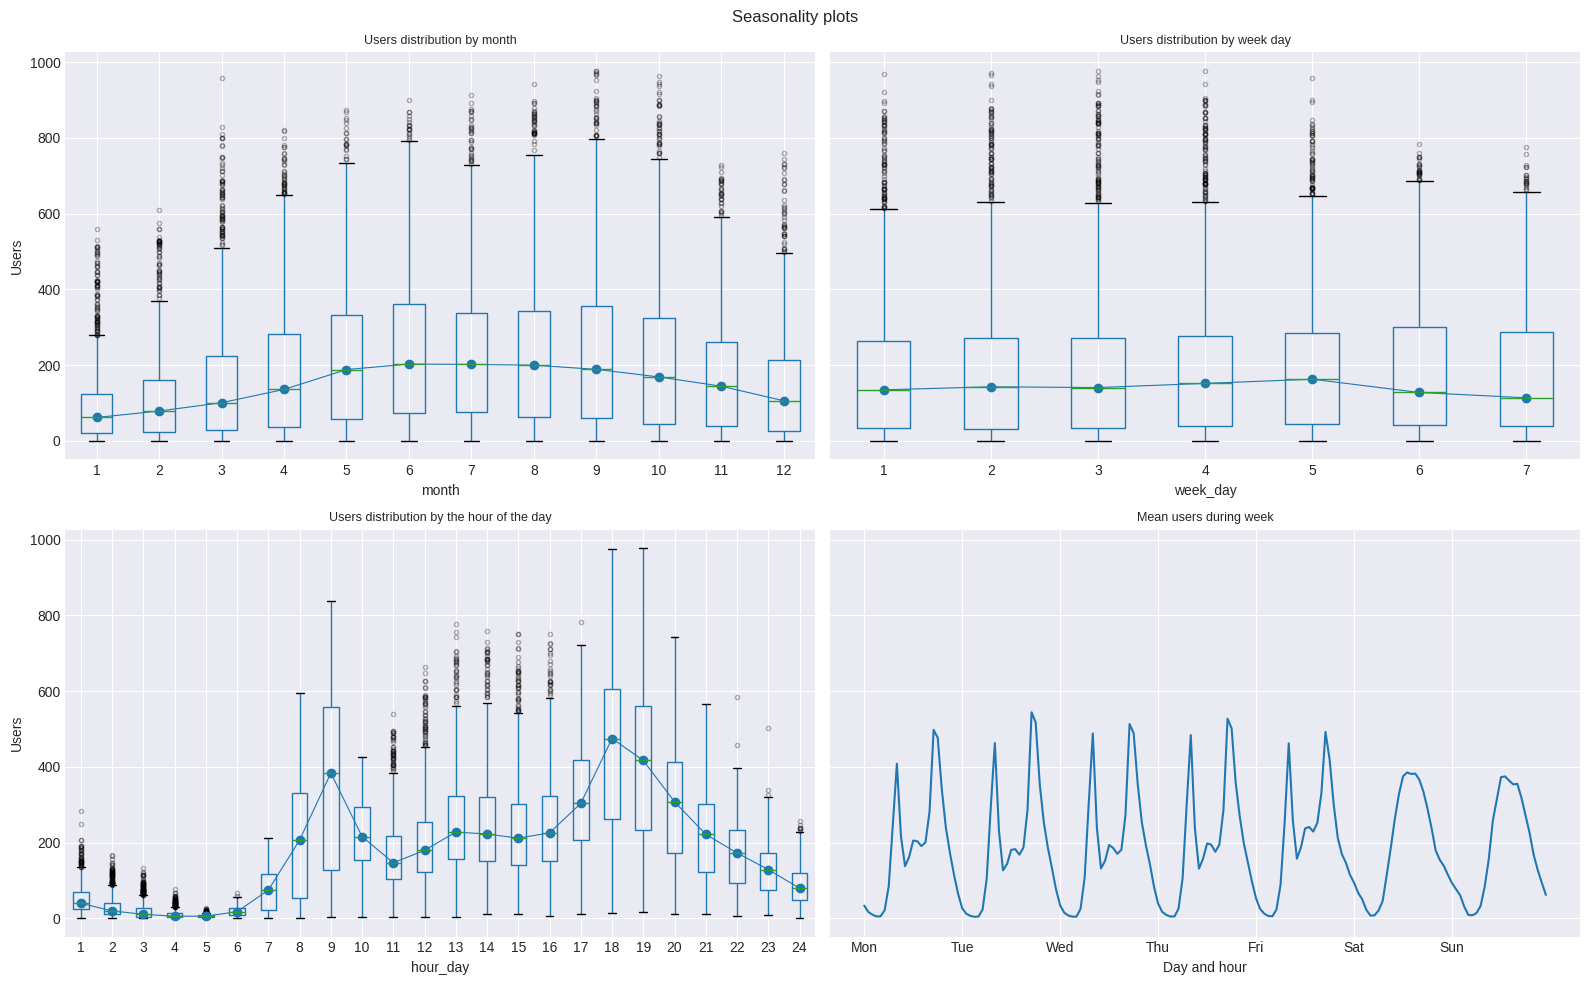

In [17]:
# Annual, weekly and daily seasonality
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=False, sharey=True)
axs = axs.ravel()

# Users distribution by month
data['month'] = data.index.month
data.boxplot(column='users', by='month', ax=axs[0], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('month')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Users')
axs[0].set_title('Users distribution by month', fontsize=9)

# Users distribution by week day
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='users', by='week_day', ax=axs[1], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('week_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Users')
axs[1].set_title('Users distribution by week day', fontsize=9)

# Users distribution by the hour of the day
data['hour_day'] = data.index.hour + 1
data.boxplot(column='users', by='hour_day', ax=axs[2], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('hour_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Users')
axs[2].set_title('Users distribution by the hour of the day', fontsize=9)

# Users distribution by week day and hour of the day
mean_day_hour = data.groupby(["week_day", "hour_day"])["users"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Mean users during week",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Day and hour",
    ylabel      = "Number of users"
)
axs[3].title.set_size(9)

fig.suptitle("Seasonality plots", fontsize=12)
fig.tight_layout()

## Plot ACF/PACF

Auto-correlation plots are a useful tool for identifying the order of an autoregressive model. The autocorrelation function (ACF) is a measure of the correlation between the time series and a lagged version of itself. The partial autocorrelation function (PACF) is a measure of the correlation between the time series and a lagged version of itself, controlling for the values of the time series at all shorter lags. These plots are useful for identifying the lags to be included in the autoregressive model.

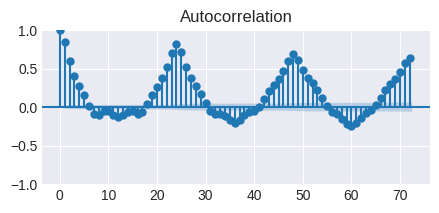

In [18]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(data['users'], ax=ax, lags=72)
plt.show()

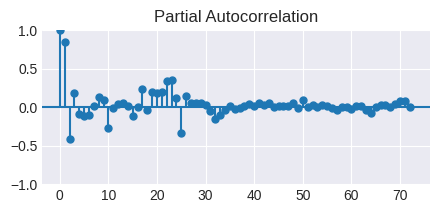

In [19]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(data['users'], ax=ax, lags=72, method='ywm')
plt.show()

In [20]:
# Top 10 lags with highest absolute partial autocorrelation
# ==============================================================================
calculate_lag_autocorrelation(
    data    = data['users'],
    n_lags  = 60,
    sort_by = "partial_autocorrelation_abs"
).head(10)

,lag,partial_autocorrelation_abs,partial_autocorrelation,autocorrelation_abs,autocorrelation
0,1,0.845220,0.845220,0.845172,0.845172
1,2,0.408349,-0.408349,0.597704,0.597704
2,23,0.355669,0.355669,0.708470,0.708470
3,22,0.343601,0.343601,0.520804,0.520804
4,25,0.332366,-0.332366,0.711256,0.711256
5,10,0.272649,-0.272649,0.046483,-0.046483
6,17,0.241984,0.241984,0.057267,-0.057267
7,19,0.199286,0.199286,0.159897,0.159897
8,21,0.193404,0.193404,0.373666,0.373666
9,3,0.182068,0.182068,0.409680,0.409680


The results of the autocorrelation study show that there is a significant correlation between the number of users in previous hours, as well as the days before, and the number of users in the future. This means that knowing the number of users during certain periods in the past could be valuable in predicting the number of users in the future.

# Data Preprocessing

# Modeling

## Baseline

In short, a simple model that can be used as a reference to assess whether more complicated models are worth implementing. 

Let use the Seasonal naive Forecaasting, which simply returns the value observed in the same period of the previuous season. 

Thanks to the EDA step, we know that there are some seasnonality in day and hour, therefore we will let the forecasting of this hour to be the same as the same hour, but previous day 

In [21]:
# Create baseline: value of the same hour of the previous day
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(days=1),
                 n_offsets = 1
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'users'])
forecaster


ForecasterEquivalentDate 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 24 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Creation date: 2025-05-17 22:30:43 
Last fit date: 2025-05-17 22:30:43 
Skforecast version: 0.15.0 
Python version: 3.10.16 
Forecaster id: None 

In [22]:
# Backtesting
# ==============================================================================
cv = TimeSeriesFold(steps = 36, initial_train_size = len(data.loc[:end_validation]))
metric_baseline, predictions = backtesting_forecaster(
                                   forecaster = forecaster,
                                   y          = data['users'],
                                   cv         = cv,
                                   metric     = 'mean_absolute_error'
                               )
metric_baseline



100%|██████████| 82/82 [00:00<00:00, 700.08it/s]


,mean_absolute_error
0,91.668716


## Multi-step processing with LightGBM

In [23]:
# Create forecaster
# ==============================================================================
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)
forecaster = ForecasterRecursive(
                regressor       = LGBMRegressor(random_state=15926, verbose=-1),
                lags            = 24,
                window_features = window_features
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'users'])
forecaster


=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_72'] 
Window size: 72 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample':
    1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-05-17 22:37:36 
Last fit date: 2025-05-17 22:37:36 
Skforecast version: 0.15.0 
Python version: 3.10.16 
Forecaster id: None

In [24]:
# predict w forecaster
forecaster.predict(steps=10)

2012-09-01 00:00:00    108.331027
2012-09-01 01:00:00     68.562982
2012-09-01 02:00:00     33.499525
2012-09-01 03:00:00     10.027583
2012-09-01 04:00:00      3.037563
2012-09-01 05:00:00     17.162543
2012-09-01 06:00:00     51.059825
2012-09-01 07:00:00    146.940053
2012-09-01 08:00:00    344.320596
2012-09-01 09:00:00    439.738683
Freq: h, Name: pred, dtype: float64

### Back testing

In order to have a robust estimate of the predictive ability of the model, a backtesting process is carried out. The backtesting process consists of generating a forecast for each observation in the test set, following the same procedure as it would be done in production, and then comparing the predicted value with the actual value.

It is highly recommended to review the documentation for the backtesting_forecaster() function to gain a better understanding of its capabilities. This will help to utilize its full potential to analyze the predictive ability of the model.

In [25]:
# Backtest model on test data
# ==============================================================================
cv = TimeSeriesFold(steps = 36, initial_train_size = len(data.loc[:end_validation]))
metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['users'],
                          cv         = cv,
                          metric     = 'mean_absolute_error'
                      )
predictions.head()

100%|██████████| 82/82 [00:00<00:00, 143.46it/s]


,pred
2012-09-01 00:00:00,108.331027
2012-09-01 01:00:00,68.562982
2012-09-01 02:00:00,33.499525
2012-09-01 03:00:00,10.027583
2012-09-01 04:00:00,3.037563


In [26]:
metric

,mean_absolute_error
0,76.464247


The prediction error of the autoregressive model achieves a lower MAE than that of the baseline model.

### Exorgenous Variable
So far, only lagged values of the time series have been used as predictors. However, it is possible to include other variables as predictors. These variables are known as exogenous variables (features) and their use can improve the predictive capacity of the model. **A very important point to keep in mind is that the values of the exogenous variables must be known at the time of prediction.**

Common examples of exogenous variables are those derived from the calendar, such as the day of the week, month, year, or holidays. Weather variables such as temperature, humidity, and wind also fall into this category, as do economic variables such as inflation and interest rates.

Next, exogenous variables are created based on calendar information, sunrise and sunset times, temperature, and holidays. **These new variables are then added to the training, validation and test sets, and used as predictors in the autoregressive model.**

In [27]:
# Calendar features
# ==============================================================================
features_to_extract = [
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables           ='index',
    features_to_extract = features_to_extract,
    drop_original       = True,
)
calendar_features = calendar_transformer.fit_transform(data)[features_to_extract]

# Sunlight features
# ==============================================================================
location = LocationInfo(
    name      = 'Washington DC',
    region    = 'USA',
    timezone  = 'US/Eastern',
    latitude  = 40.516666666666666,
    longitude = -77.03333333333333
)
sunrise_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise'].hour
    for date in data.index
]
sunset_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset'].hour
    for date in data.index
]
sun_light_features = pd.DataFrame({
                        'sunrise_hour': sunrise_hour,
                        'sunset_hour': sunset_hour}, 
                        index = data.index
                     )
sun_light_features['daylight_hours'] = (
    sun_light_features['sunset_hour'] - sun_light_features['sunrise_hour']
)
sun_light_features["is_daylight"] = np.where(
    (data.index.hour >= sun_light_features["sunrise_hour"])
    & (data.index.hour < sun_light_features["sunset_hour"]),
    1,
    0,
)

# Holiday features
# ==============================================================================
holiday_features = data[['holiday']].astype(int)
holiday_features['holiday_previous_day'] = holiday_features['holiday'].shift(24)
holiday_features['holiday_next_day'] = holiday_features['holiday'].shift(-24)

# Rolling windows of temperature
# ==============================================================================
wf_transformer = WindowFeatures(
    variables   = ["temp"],
    window      = ["1D", "7D"],
    functions   = ["mean", "max", "min"],
    freq        = "h",
)
temp_features = wf_transformer.fit_transform(data[['temp']])


# Merge all exogenous variables
# ==============================================================================
assert all(calendar_features.index == sun_light_features.index)
assert all(calendar_features.index == temp_features.index)
assert all(calendar_features.index == holiday_features.index)
df_exogenous_features = pd.concat([
    calendar_features,
    sun_light_features,
    temp_features,
    holiday_features
], axis=1)

# Due to the creation of moving averages, there are missing values at the beginning
# of the series. And due to holiday_next_day there are missing values at the end.
df_exogenous_features = df_exogenous_features.iloc[7 * 24:, :]
df_exogenous_features = df_exogenous_features.iloc[:-24, :]
df_exogenous_features.head(3)

,month,week,day_of_week,hour,sunrise_hour,sunset_hour,daylight_hours,is_daylight,temp,temp_window_1D_mean,temp_window_1D_max,temp_window_1D_min,temp_window_7D_mean,temp_window_7D_max,temp_window_7D_min,holiday,holiday_previous_day,holiday_next_day
date_time,,,,,,,,,,,,,,,,,,
2011-01-08 00:00:00,1,1,5,0,7,16,9,0,7.38,8.063333,9.02,6.56,10.127976,18.86,4.92,0,0.0,0.0
2011-01-08 01:00:00,1,1,5,1,7,16,9,0,7.38,8.029167,9.02,6.56,10.113333,18.86,4.92,0,0.0,0.0
2011-01-08 02:00:00,1,1,5,2,7,16,9,0,7.38,7.995000,9.02,6.56,10.103571,18.86,4.92,0,0.0,0.0


### Feature with a cyclical pattern
Certain aspects of the calendar, such as hours or days, are cyclical. For example, the hour-day cycle ranges from 0 to 23 hours. These types of features can be handled in several ways, each with its advantages and disadvantages.

- One approach is to use the features directly as numeric values without any transformation. This method avoids creating a lot of new features, but may impose an incorrect linear order on the values. For example, hour 23 of one day and hour 00 of the next are very far apart in their linear representation, when in fact there is only one hour difference between them.

- Another possibility is to treat cyclical features as categorical variables to avoid imposing a linear order. However, this approach may result in the loss of the cyclical information inherent in the variable.

- There is a third way to deal with cyclical features that is often preferred to the other two methods. This involves transforming the features using the sine and cosine of their period. This approach generates only two new features that capture the cyclicality of the data more accurately than the previous two methods because it preserves the natural order of the feature and avoids imposing a linear order.


In [28]:
# Cliclical encoding of calendar and sunlight features
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
    "sunrise_hour",
    "sunset_hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 7,
    "hour": 24,
    "sunrise_hour": 24,
    "sunset_hour": 24,
}
cyclical_encoder = CyclicalFeatures(
    variables     = features_to_encode,
    max_values    = max_values,
    drop_original = False
)

df_exogenous_features = cyclical_encoder.fit_transform(df_exogenous_features)
df_exogenous_features.head(3)


,month,week,day_of_week,hour,sunrise_hour,sunset_hour,daylight_hours,is_daylight,temp,temp_window_1D_mean,...,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,sunrise_hour_sin,sunrise_hour_cos,sunset_hour_sin,sunset_hour_cos
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-08 00:00:00,1,1,5,0,7,16,9,0,7.38,8.063333,...,0.120537,0.992709,-0.974928,-0.222521,0.000000,1.000000,0.965926,-0.258819,-0.866025,-0.5
2011-01-08 01:00:00,1,1,5,1,7,16,9,0,7.38,8.029167,...,0.120537,0.992709,-0.974928,-0.222521,0.258819,0.965926,0.965926,-0.258819,-0.866025,-0.5
2011-01-08 02:00:00,1,1,5,2,7,16,9,0,7.38,7.995000,...,0.120537,0.992709,-0.974928,-0.222521,0.500000,0.866025,0.965926,-0.258819,-0.866025,-0.5


### Feature Interaction
In many cases, exogenous variables are not isolated. Rather, their effect on the target variable depends on the value of other variables. For example, the effect of temperature on electricity demand depends on the time of day. The interaction between the exogenous variables can be captured by new variables that are obtained by multiplying existing variables together. This interactions are easily obtained with the PolynomialFeatures class from scikit-learn.


In [29]:
# Interaction between exogenous variables
# ==============================================================================
transformer_poly = PolynomialFeatures(
                        degree           = 2,
                        interaction_only = True,
                        include_bias     = False
                    ).set_output(transform="pandas")
poly_cols = [
    'month_sin', 
    'month_cos',
    'week_sin',
    'week_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'hour_sin',
    'hour_cos',
    'sunrise_hour_sin',
    'sunrise_hour_cos',
    'sunset_hour_sin',
    'sunset_hour_cos',
    'daylight_hours',
    'is_daylight',
    'holiday_previous_day',
    'holiday_next_day',
    'temp_window_1D_mean',
    'temp_window_1D_min',
    'temp_window_1D_max',
    'temp_window_7D_mean',
    'temp_window_7D_min',
    'temp_window_7D_max',
    'temp',
    'holiday'
]
poly_features = transformer_poly.fit_transform(df_exogenous_features[poly_cols])
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")
assert all(poly_features.index == df_exogenous_features.index)
df_exogenous_features = pd.concat([df_exogenous_features, poly_features], axis=1)
df_exogenous_features.head(3)


,month,week,day_of_week,hour,sunrise_hour,sunset_hour,daylight_hours,is_daylight,temp,temp_window_1D_mean,...,poly_temp_window_7D_mean__temp_window_7D_min,poly_temp_window_7D_mean__temp_window_7D_max,poly_temp_window_7D_mean__temp,poly_temp_window_7D_mean__holiday,poly_temp_window_7D_min__temp_window_7D_max,poly_temp_window_7D_min__temp,poly_temp_window_7D_min__holiday,poly_temp_window_7D_max__temp,poly_temp_window_7D_max__holiday,poly_temp__holiday
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-08 00:00:00,1,1,5,0,7,16,9,0,7.38,8.063333,...,49.829643,191.013631,74.744464,0.0,92.7912,36.3096,0.0,139.1868,0.0,0.0
2011-01-08 01:00:00,1,1,5,1,7,16,9,0,7.38,8.029167,...,49.757600,190.737467,74.636400,0.0,92.7912,36.3096,0.0,139.1868,0.0,0.0
2011-01-08 02:00:00,1,1,5,2,7,16,9,0,7.38,7.995000,...,49.709571,190.553357,74.564357,0.0,92.7912,36.3096,0.0,139.1868,0.0,0.0


### Categorical Feature
There are several approaches to incorporating categorical variables into LightGBM (and other gradient boosting frameworks):

- One option is to transform the data by converting categorical values to numerical values using methods such as one-hot encoding or ordinal encoding. This approach is applicable to all machine learning models.

- Alternatively, LightGBM can handle categorical variables internally without the need for preprocessing. This can be done automatically by setting the parameter categorical_features='auto' and encoding the variables as the category datatype within a Pandas DataFrame. As another option, users can specify the names of the features to be treated as categorical by passing a list of column names to the categorical_features parameter.

There is no one method that is always better than the others. General rules are:

- When the cardinality of categorical variables is high (many different values), it is better to use the native support for categorical variables than to use one-hot encoding.

- With one-hot encoded data, more split points (i.e., more depth) are needed to recover an equivalent split that could be obtained with a single split point using native handling.

- When a categorical variable is converted to multiple dummy variables using one-hot, its importance is diluted, making the analysis of the importance of the features more complex to interpret.


In [30]:
# Store categorical variables as category type
# ==============================================================================
data["weather"] = data["weather"].astype("category")